In [1]:
%load_ext autoreload
%autoreload 2
import sys
from pathlib import Path
path = str(Path.cwd().parent)
print(path)
sys.path.insert(1, path)

import numpy as np
import pandas as pd

/home/ec2-user/git-repos/skforecast


In [2]:
import os
os.environ["KERAS_BACKEND"] = "torch"
os.environ["CUDA_VISIBLE_DEVICES"] = "-1"

import numpy as np
import pandas as pd

from skforecast.deep_learning import ForecasterRnn
from skforecast.deep_learning.utils import create_and_compile_model, create_and_compile_model_exog, create_and_compile_model_exog_2

# set backend torch
import torch
import keras
print(keras.__version__)
print(keras.backend.backend())



3.7.0
torch


# Test with Ximo

In [40]:
from skforecast.datasets import fetch_dataset
data = fetch_dataset('bike_sharing_extended_features')

end_train = '2012-03-31 23:59:00'
end_validation = '2012-08-31 23:59:00'
data_train = data.loc[: end_train, :]
data_val = data.loc[end_train:end_validation, :]
data_test = data.loc[end_validation:, :]

exog_features = [ 'month_sin', 'month_cos', 'week_of_year_sin', 'week_of_year_cos', 'week_day_sin', 'week_day_cos', 'hour_day_sin', 'hour_day_cos', 'sunrise_hour_sin', 'sunrise_hour_cos', 'sunset_hour_sin', 'sunset_hour_cos', 'holiday_previous_day', 'holiday_next_day', 'temp_roll_mean_1_day', 'temp_roll_mean_7_day', 'temp_roll_max_1_day', 'temp_roll_min_1_day', 'temp_roll_max_7_day', 'temp_roll_min_7_day', 'temp', 'holiday' ]


bike_sharing_extended_features
------------------------------
Hourly usage of the bike share system in the city of Washington D.C. during the
years 2011 and 2012. In addition to the number of users per hour, the dataset
was enriched by introducing supplementary features. Addition includes calendar-
based variables (day of the week, hour of the day, month, etc.), indicators for
sunlight, incorporation of rolling temperature averages, and the creation of
polynomial features generated from variable pairs. All cyclic variables are
encoded using sine and cosine functions to ensure accurate representation.
Fanaee-T,Hadi. (2013). Bike Sharing Dataset. UCI Machine Learning Repository.
https://doi.org/10.24432/C5W894.
Shape of the dataset: (17352, 90)


Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ series_input        │ (None, 24, 1)     │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_3 (LSTM)       │ (None, 100)       │     40,800 │ series_input[0][… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ repeat_vector_3     │ (None, 36, 100)   │          0 │ lstm_3[0][0]      │
│ (RepeatVector)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ exog_input          │ (None, 36, 22)    │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_3       │ (None, 36, 122)   │          0 │ repeat_vector_3[… │
│ (Concatenate)       │                   │            │ exog_input[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ time_distributed_9  │ (None, 36, 128)   │     15,744 │ concatenate_3[0]… │
│ (TimeDistributed)   │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ time_distributed_10 │ (None, 36, 64)    │      8,256 │ time_distributed… │
│ (TimeDistributed)   │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ time_distributed_11 │ (None, 36, 1)     │         65 │ time_distributed… │
│ (TimeDistributed)   │                   │            │                   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 64,865 (253.38 KB)

 Trainable params: 64,865 (253.38 KB)

 Non-trainable params: 0 (0.00 B)

/home/ec2-user/git-repos/skforecast/venv_skforecast_0.15/lib/python3.12/site-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'adam', because it has 20 variables whereas the saved optimizer has 2 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


In [43]:
lags = 24
steps = 36
levels = ["users"]
activation = "relu"
optimizer = keras.optimizers.Adam(learning_rate=0.01)
loss = keras.losses.MeanSquaredError()
recurrent_units = 100
dense_units = [128, 64]

model = create_and_compile_model_exog_2(
    series=data[levels],
    lags=lags,
    steps=steps,
    levels=levels,
    exog=data[exog_features],
    recurrent_units=recurrent_units,
    dense_units=dense_units,
    activation=activation,
    optimizer=optimizer,
    loss=loss,
)

model.summary()

# ==============================================================================

forecaster = ForecasterRnn(
    regressor=model,
    levels=levels,
    fit_kwargs={
        "epochs": 3,  # Number of epochs to train the model.
        "batch_size": 2048,  # Batch size to train the model.
    },
)    


# Backtesting model with exogenous variables on test data 
# # ============================================================================== 
from skforecast.model_selection import TimeSeriesFold, backtesting_forecaster_multiseries
 
cv = TimeSeriesFold( steps = 36, initial_train_size = len(data[:end_validation]), refit = False, allow_incomplete_fold=False)
metric, predictions = backtesting_forecaster_multiseries( forecaster = forecaster, series = data[levels], exog = data[exog_features], cv = cv, metric = 'mean_absolute_error' )

metric

Using device: cpu
Epoch 1/3
8/8 ━━━━━━━━━━━━━━━━━━━━ 3s 411ms/step - loss: 0.2141
Epoch 2/3
8/8 ━━━━━━━━━━━━━━━━━━━━ 3s 346ms/step - loss: 0.0351
Epoch 3/3
8/8 ━━━━━━━━━━━━━━━━━━━━ 3s 345ms/step - loss: 0.0288





























100%|██████████| 80/80 [00:03<00:00, 26.19it/s]


,levels,mean_absolute_error
0,users,182.744942


In [44]:
lags = 24
steps = 36
levels = ["users"]
activation = "relu"
optimizer = keras.optimizers.Adam(learning_rate=0.01)
loss = keras.losses.MeanSquaredError()
recurrent_units = 100
dense_units = [128, 64]

model = create_and_compile_model_exog_2(
    series=data[levels],
    lags=lags,
    steps=steps,
    levels=levels,
    # exog=data[exog_features],
    recurrent_units=recurrent_units,
    dense_units=dense_units,
    activation=activation,
    optimizer=optimizer,
    loss=loss,
)

model.summary()

# ==============================================================================

forecaster = ForecasterRnn(
    regressor=model,
    levels=levels,
    fit_kwargs={
        "epochs": 3,  # Number of epochs to train the model.
        "batch_size": 2048,  # Batch size to train the model.
    },
)    


# Backtesting model with exogenous variables on test data 
# # ============================================================================== 
from skforecast.model_selection import TimeSeriesFold, backtesting_forecaster_multiseries
 
cv = TimeSeriesFold( steps = 36, initial_train_size = len(data[:end_validation]), refit = False, allow_incomplete_fold=False)
metric, predictions = backtesting_forecaster_multiseries(
    forecaster = forecaster, 
    series = data[levels], 
    # exog = data[exog_features], 
    cv = cv, 
    metric = 'mean_absolute_error'
    )

metric

Model: "functional_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ series_input (InputLayer)       │ (None, 24, 1)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_4 (LSTM)                   │ (None, 100)            │        40,800 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ repeat_vector_4 (RepeatVector)  │ (None, 36, 100)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_12             │ (None, 36, 128)        │        12,928 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_13             │ (None, 36, 64)         │         8,256 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_14             │ (None, 36, 1)          │            65 │
│ (TimeDistributed)               │                        │               │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 62,049 (242.38 KB)

 Trainable params: 62,049 (242.38 KB)

 Non-trainable params: 0 (0.00 B)

/home/ec2-user/git-repos/skforecast/venv_skforecast_0.15/lib/python3.12/site-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'adam', because it has 20 variables whereas the saved optimizer has 2 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


Using device: cpu
Epoch 1/3
8/8 ━━━━━━━━━━━━━━━━━━━━ 2s 297ms/step - loss: 0.0716
Epoch 2/3
8/8 ━━━━━━━━━━━━━━━━━━━━ 2s 300ms/step - loss: 0.0363
Epoch 3/3
8/8 ━━━━━━━━━━━━━━━━━━━━ 3s 311ms/step - loss: 0.0324





























100%|██████████| 80/80 [00:02<00:00, 29.39it/s]


,levels,mean_absolute_error
0,users,170.711783


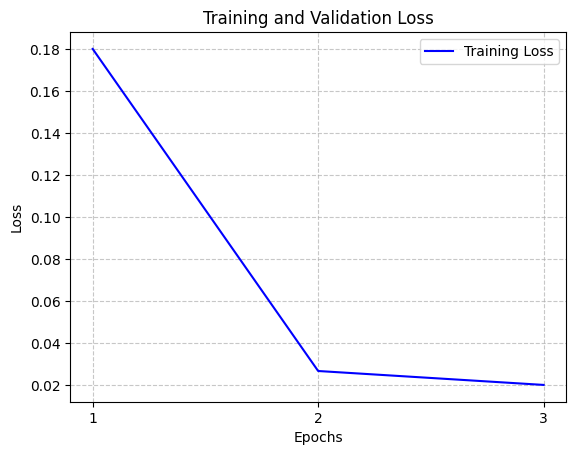

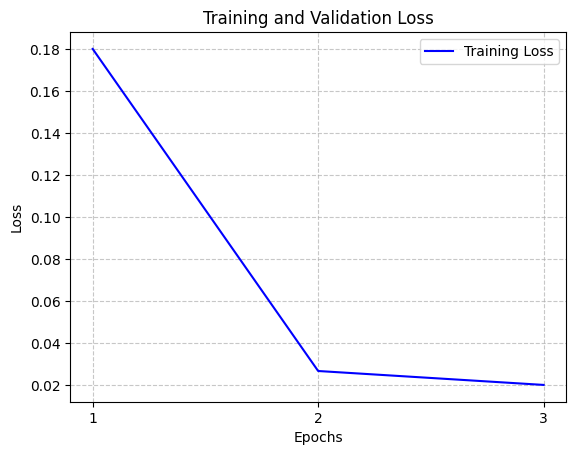

In [28]:
forecaster.plot_history()

# End test

In [ ]:
series = pd.DataFrame(
    {
        "1": np.arange(50.),
        "2": np.arange(50., 100.),
        "3": np.arange(100., 150.),
    }
)

exog = pd.DataFrame(
    {
        "exog_1": np.arange(50.),
        "exog_2": np.arange(50., 100.),
    }
)

exog_predict = pd.DataFrame(
    {
        "exog_1": np.arange(50., 60),
        "exog_2": np.arange(100., 110.),
    },
    index=pd.RangeIndex(start=50, stop=60, step=1)
)

In [3]:
torch.device("cuda" if torch.cuda.is_available() else "cpu")

device(type='cpu')

In [4]:
series.shape, exog.shape, exog_predict.shape

((50, 3), (50, 2), (10, 2))

In [5]:
50-(4+5-1)

42

In [6]:
lags = 4
steps = 5
levels = ["1", "2"]
activation = "relu"
optimizer = keras.optimizers.Adam(learning_rate=0.01)
loss = keras.losses.MeanSquaredError()
recurrent_units = 100
dense_units = [128, 64]

model = create_and_compile_model_exog_2(
    series=series,
    lags=lags,
    steps=steps,
    levels=levels,
    exog=exog,
    recurrent_units=recurrent_units,
    dense_units=dense_units,
    activation=activation,
    optimizer=optimizer,
    loss=loss,
)

model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ series_input        │ (None, 4, 3)      │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm (LSTM)         │ (None, 100)       │     41,600 │ series_input[0][… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ repeat_vector       │ (None, 5, 100)    │          0 │ lstm[0][0]        │
│ (RepeatVector)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ exog_input          │ (None, 5, 2)      │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate         │ (None, 5, 102)    │          0 │ repeat_vector[0]… │
│ (Concatenate)       │                   │            │ exog_input[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ time_distributed    │ (None, 5, 128)    │     13,184 │ concatenate[0][0] │
│ (TimeDistributed)   │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ time_distributed_1  │ (None, 5, 64)     │      8,256 │ time_distributed… │
│ (TimeDistributed)   │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ time_distributed_2  │ (None, 5, 2)      │        130 │ time_distributed… │
│ (TimeDistributed)   │                   │            │                   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 63,170 (246.76 KB)

 Trainable params: 63,170 (246.76 KB)

 Non-trainable params: 0 (0.00 B)

In [7]:
lyr = model.layers[-1]


In [8]:
forecaster = ForecasterRnn(model, levels, lags=lags, transformer_series=None, transformer_exog=None)
forecaster

/home/ec2-user/git-repos/skforecast/venv_skforecast_0.15/lib/python3.12/site-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'adam', because it has 20 variables whereas the saved optimizer has 2 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


============= 
ForecasterRnn 
============= 
Regressor: <Functional name=functional, built=True> 
Target series (levels): ['1', '2'] 
Lags: [1 2 3 4] 
Window size: 4 
Maximum steps to predict: [1 2 3 4 5] 
Multivariate series: None 
Exogenous included: False 
Exogenous names: None 
Transformer for series: None 
Transformer for exog: None 
Training range: None 
Training index type: None 
Training index frequency: None 
Regressor parameters: {'name': 'functional', 'trainable': True, 'layers': [{'module': 'keras.layers', 'class_name': 'InputLayer', 'config': {'batch_shape': (None, 4, 3), 'dtype': 'float32', 'sparse': False, 'name': 'series_input'}, 'registered_name': None, 'name': 'series_input', 'inbound_nodes': []}, {'module': 'keras.layers', 'class_name': 'LSTM', 'config': {'name': 'lstm', 'trainable': True, 'dtype': {'module': 'keras', 'class_name': 'DTypePolicy', 'config': {'name': 'float32'}, 'registered_name': None}, 'return_sequences': False, 'return_state': False, 'go_backwards': False, 'stateful': False, 'unroll': False, 'zero_output_for_mask': False, 'units': 100, 'activation': 'relu', 'recurrent_activation': 'sigmoid', 'use_bias': True, 'kernel_initializer': {'module': 'keras.initializers', 'class_name': 'GlorotUniform', 'config': {'seed': None}, 'registered_name': None}, 'recurrent_initializer': {'module': 'keras.initializers', 'class_name': 'Orthogonal', 'config': {'seed': None, 'gain': 1.0}, 'registered_name': None}, 'bias_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'unit_forget_bias': True, 'kernel_regularizer': None, 'recurrent_regularizer': None, 'bias_regularizer': None, 'activity_regularizer': None, 'kernel_constraint': None, 'recurrent_constraint': None, 'bias_constraint': None, 'dropout': 0.0, 'recurrent_dropout': 0.0, 'seed': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 4, 3]}, 'name': 'lstm', 'inbound_nodes': [{'args': ({'class_name': '__keras_tensor__', 'config': {'shape': (None, 4, 3), 'dtype': 'float32', 'keras_history': ['series_input', 0, 0]}},), 'kwargs': {'training': False, 'mask': None}}]}, {'module': 'keras.layers', 'class_name': 'RepeatVector', 'config': {'name': 'repeat_vector', 'trainable': True, 'dtype': {'module': 'keras', 'class_name': 'DTypePolicy', 'config': {'name': 'float32'}, 'registered_name': None}, 'n': 5}, 'registered_name': None, 'build_config': {'input_shape': [None, 100]}, 'name': 'repeat_vector', 'inbound_nodes': [{'args': ({'class_name': '__keras_tensor__', 'config': {'shape': (None, 100), 'dtype': 'float32', 'keras_history': ['lstm', 0, 0]}},), 'kwargs': {}}]}, {'module': 'keras.layers', 'class_name': 'InputLayer', 'config': {'batch_shape': (None, 5, 2), 'dtype': 'float32', 'sparse': False, 'name': 'exog_input'}, 'registered_name': None, 'name': 'exog_input', 'inbound_nodes': []}, {'module': 'keras.layers', 'class_name': 'Concatenate', 'config': {'name': 'concatenate', 'trainable': True, 'dtype': {'module': 'keras', 'class_name': 'DTypePolicy', 'config': {'name': 'float32'}, 'registered_name': None}, 'axis': -1}, 'registered_name': None, 'build_config': {'input_shape': [[None, 5, 100], [None, 5, 2]]}, 'name': 'concatenate', 'inbound_nodes': [{'args': ([{'class_name': '__keras_tensor__', 'config': {'shape': (None, 5, 100), 'dtype': 'float32', 'keras_history': ['repeat_vector', 0, 0]}}, {'class_name': '__keras_tensor__', 'config': {'shape': (None, 5, 2), 'dtype': 'float32', 'keras_history': ['exog_input', 0, 0]}}],), 'kwargs': {}}]}, {'module': 'keras.layers', 'class_name': 'TimeDistributed', 'config': {'name': 'time_distributed', 'trainable': True, 'dtype': {'module': 'keras', 'class_name': 'DTypePolicy', 'config': {'name': 'float32'}, 'registered_name': None}, 'layer': {'module': 'keras.layers', 'class_name': 'Dense', 'config': {'name': 'dense', 'trainable': True, 'dtype': {'module': 'keras', 'class_name': 'DTypePolicy', 'config': {'name': 'float32'}, 'registered_name': None}, 'units': 

In [9]:
X_train, exog_train, y_train, dimension_names = forecaster.create_train_X_y(series, exog)

In [10]:
series.shape, exog.shape, y_train.shape, exog_train.shape

((50, 3), (50, 2), (42, 5, 2), (42, 5, 2))

In [11]:
exog.head(10)

,exog_1,exog_2
0,0.0,50.0
1,1.0,51.0
2,2.0,52.0
3,3.0,53.0
4,4.0,54.0
5,5.0,55.0
6,6.0,56.0
7,7.0,57.0
8,8.0,58.0
9,9.0,59.0


In [12]:
y_train[:5,:,0]

array([[ 4.,  5.,  6.,  7.,  8.],
       [ 5.,  6.,  7.,  8.,  9.],
       [ 6.,  7.,  8.,  9., 10.],
       [ 7.,  8.,  9., 10., 11.],
       [ 8.,  9., 10., 11., 12.]])

In [13]:
exog_train[:5,:,0]

array([[ 4.,  5.,  6.,  7.,  8.],
       [ 5.,  6.,  7.,  8.,  9.],
       [ 6.,  7.,  8.,  9., 10.],
       [ 7.,  8.,  9., 10., 11.],
       [ 8.,  9., 10., 11., 12.]])

In [14]:
series.head(5)

,1,2,3
0,0.0,50.0,100.0
1,1.0,51.0,101.0
2,2.0,52.0,102.0
3,3.0,53.0,103.0
4,4.0,54.0,104.0


In [15]:
exog_train[:5,:,0]

array([[ 4.,  5.,  6.,  7.,  8.],
       [ 5.,  6.,  7.,  8.,  9.],
       [ 6.,  7.,  8.,  9., 10.],
       [ 7.,  8.,  9., 10., 11.],
       [ 8.,  9., 10., 11., 12.]])

In [16]:
y_train[:5,:,0]

array([[ 4.,  5.,  6.,  7.,  8.],
       [ 5.,  6.,  7.,  8.,  9.],
       [ 6.,  7.,  8.,  9., 10.],
       [ 7.,  8.,  9., 10., 11.],
       [ 8.,  9., 10., 11., 12.]])

In [17]:
X_train[:5,:,0]

array([[0., 1., 2., 3.],
       [1., 2., 3., 4.],
       [2., 3., 4., 5.],
       [3., 4., 5., 6.],
       [4., 5., 6., 7.]])

In [18]:
exog.head(2)

,exog_1,exog_2
0,0.0,50.0
1,1.0,51.0


In [31]:
# forecaster.fit(
#     series=series, store_in_sample_residuals=True
# )

forecaster.fit(
    series=series,  exog=exog, store_in_sample_residuals=True
)

Using device: cpu
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 2539.8674


In [34]:
X_eval, exog_eval, y_train, dimension_names = forecaster.create_train_X_y(
    series=series, exog=exog
)



In [35]:
X_eval.shape, exog_eval.shape, X_eval.shape

((42, 4, 3), (42, 5, 2), (42, 4, 3))

In [36]:
forecaster.regressor.predict([X_eval, exog_eval]).shape

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


(42, 5, 2)

In [37]:
exog_eval[:1].shape

(1, 5, 2)

In [38]:
X_train, exog_train, y_train, dimension_names = forecaster.create_train_X_y(
    series=series, exog=exog
)

In [39]:
exog_predict

,exog_1,exog_2
50,50.0,100.0
51,51.0,101.0
52,52.0,102.0
53,53.0,103.0
54,54.0,104.0
55,55.0,105.0
56,56.0,106.0
57,57.0,107.0
58,58.0,108.0
59,59.0,109.0


In [40]:
exog_predict[["exog_1"]]

,exog_1
50,50.0
51,51.0
52,52.0
53,53.0
54,54.0
55,55.0
56,56.0
57,57.0
58,58.0
59,59.0


In [41]:
# inputs = forecaster._create_predict_inputs(
#     steps=3, levels=['1', '2']
# )

X, X_col_names, steps, levels, prediction_index = forecaster._create_predict_inputs(
    steps=[1,3], levels=['1'], exog=exog_predict
)
print(X[0].shape)
print(X[1].shape)
print(X_col_names)
print(steps)
print(levels)
print(prediction_index)

(1, 4, 3)
(1, 5, 2)
[]
[1, 3]
['1']
Index([50, 52], dtype='int64')


In [42]:
predictions = forecaster.predict(steps=[1,3,4], exog=exog_predict, levels=['1', "2"])
predictions

[array([[[ 46.,  96., 146.],
        [ 47.,  97., 147.],
        [ 48.,  98., 148.],
        [ 49.,  99., 149.]]]), array([[[ 50., 100.],
        [ 51., 101.],
        [ 52., 102.],
        [ 53., 103.],
        [ 54., 104.]]])]
[[[ 11.878754 156.286   ]
  [ 11.967281 156.97054 ]
  [ 12.055815 157.65506 ]
  [ 12.144343 158.33957 ]
  [ 12.232871 159.0241  ]]]


,level,pred
50,1,11.878754
50,2,156.285995
52,1,12.055815
52,2,157.655060
53,1,12.144343
53,2,158.339569


In [43]:
X_col_names

[]

In [44]:
X[0].shape

(1, 4, 3)

In [45]:
X[1]

array([[[ 50., 100.],
        [ 51., 101.],
        [ 52., 102.],
        [ 53., 103.],
        [ 54., 104.]]])

In [46]:
exog_predict

,exog_1,exog_2
50,50.0,100.0
51,51.0,101.0
52,52.0,102.0
53,53.0,103.0
54,54.0,104.0
55,55.0,105.0
56,56.0,106.0
57,57.0,107.0
58,58.0,108.0
59,59.0,109.0


In [47]:
np.stack(X[1], axis=2).shape

(5, 2, 1)

In [48]:
X[1]

array([[[ 50., 100.],
        [ 51., 101.],
        [ 52., 102.],
        [ 53., 103.],
        [ 54., 104.]]])

In [49]:
forecaster.regressor.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ series_input        │ (None, 4, 3)      │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm (LSTM)         │ (None, 100)       │     41,600 │ series_input[0][… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ repeat_vector       │ (None, 5, 100)    │          0 │ lstm[0][0]        │
│ (RepeatVector)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ exog_input          │ (None, 5, 2)      │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate         │ (None, 5, 102)    │          0 │ repeat_vector[0]… │
│ (Concatenate)       │                   │            │ exog_input[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ time_distributed    │ (None, 5, 128)    │     13,184 │ concatenate[0][0] │
│ (TimeDistributed)   │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ time_distributed_1  │ (None, 5, 64)     │      8,256 │ time_distributed… │
│ (TimeDistributed)   │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ time_distributed_2  │ (None, 5, 2)      │        130 │ time_distributed… │
│ (TimeDistributed)   │                   │            │                   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 189,512 (740.28 KB)

 Trainable params: 63,170 (246.76 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 126,342 (493.52 KB)

In [50]:
predictions = forecaster._predict_interval_conformal(steps=3, exog=exog_predict, levels=None)
predictions

,level,pred,lower_bound,upper_bound
50,1,11.878754,-20.124753,43.882260
50,2,156.285995,104.713898,207.858092
51,1,11.967281,-20.944008,44.878570
51,2,156.970535,105.736727,208.204343
52,1,12.055815,-21.765919,45.877549
52,2,157.655060,106.743728,208.566392


In [51]:
predictions = forecaster._predict_interval_conformal(steps=3, exog=exog_predict, levels=['1'])
predictions

,level,pred,lower_bound,upper_bound
50,1,11.878754,-20.124753,43.882260
51,1,11.967281,-20.944008,44.878570
52,1,12.055815,-21.765919,45.877549
